
**<h1><span style="color:red"><u>Fraud</u></span></h1>**
**Réalisé par : Toullec Nastassia, Marie Stéphanie et Abdelaziz Sayad**

### <span style="color:yellow"> 0. Importation des librairies</span> 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency 
import warnings
from scipy.stats import pearsonr
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import statsmodels.api
warnings.filterwarnings('ignore')
%matplotlib inline

## <span style="color:red"> I. Audit des données</span> 

Le jeu de données que nous allons utiliser, recense diverses caractéristiques d'utilisateurs et leur transactions.
Le but de notre audit est de predire si une transaction est fraudeuse.

Le dataset comporte <strong>11 colonnes</strong>, pour environ <strong>151113 lignes</strong>.
Les variables sont les suivantes :

- <strong>user_id</strong>	identifiant d'utilisateur
- <strong>signup_time</strong>	heure de connexion
- <strong>purchase_time</strong>	heure d'achat
- <strong>purchase_value</strong>	montant de la transaction
- <strong>device_id</strong>	identifiant du moyen de connexion
- <strong>source</strong>	moyen d'accés au site
- <strong>browser</strong>	navigateur utilisé
- <strong>sex</strong>	sexe
- <strong>age</strong>	age
- <strong>ip_adress</strong>	adresse IP de l'utilisateur
- <strong>is_fraud</strong>	variable cible: identifiant de la fraud

Le jeu de données qui nous intéresse ici contient dix variables explicatives.
La variable expliquée est <strong>is_fraud</strong> soit 0 non frauduleux et des 1 pour frauduleux . 
La problématique est la clasification avec apprentissage supervisé.

### <span style="color:blue"> **A. Exploration un jeu de données**</span> 

<span style="color:green"> **1. Chargement des données**</span> 

Nous chargeons les données et affichons les premières lignes.

In [3]:
df = pd.read_csv(filepath_or_buffer = 'fraud.csv',
                           sep = ',',
                           header = 0)
df.head(10)                    

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud
0,22058,2015-02-24 22:55:49,2015-04-18 2:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 1:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 7:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
5,159135,2015-05-21 6:03:03,2015-07-09 8:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0
6,50116,2015-08-01 22:40:52,2015-08-27 3:37:57,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,0
7,360585,2015-04-06 7:35:45,2015-05-25 17:21:14,27,HPUCUYLMJBYFW,Ads,Opera,M,34,1.692459e+09,0
8,159045,2015-04-21 23:38:34,2015-06-02 14:01:54,30,ILXYDOZIHOOHT,SEO,IE,F,43,3.719094e+09,0
9,182338,2015-01-25 17:49:49,2015-03-23 23:05:42,62,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,0


<span style="color:green"> **2. Nettoyage du jeu de données**</span> 

<strong>Nous recréons les variables temporelles pour analyser la temporalité des données.</strong>

1/ Les variables signup_time et purchase_time, sont divisées chacune par date et heure, nous permettant de créer 4 variables supplémentaires :
<ul>
    <li>signup_day</li>
    <li>signup_time</li>
    <li>purchase_day</li>
    <li>purshase_time</li>
</ul>

In [4]:
#Les variables signup_time et purchase_time se composent des dates avec les heures, 
#pour mieux visualiser ces donnés on va les séparer
df['signup_day'] = df['signup_time'].apply(lambda time: time.split( )[0])
df['signup_time'] = df['signup_time'].apply(lambda time: time.split( )[1])
df['purchase_day'] = df['purchase_time'].apply(lambda time: time.split( )[0])
df['purchase_time'] = df['purchase_time'].apply(lambda time: time.split( )[1]) 

df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud,signup_day,purchase_day
0,22058,22:55:49,2:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,2015-02-24,2015-04-18
1,333320,20:39:50,1:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,2015-06-07,2015-06-08
2,1359,18:52:44,18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,2015-01-01,2015-01-01
3,150084,21:13:25,13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,2015-04-28,2015-05-04
4,221365,7:09:52,18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,2015-07-21,2015-09-09


2/ puis nous divisons chacune des variables signup_day et purchase_day en 3 variables distinctes.
Ainsi la date de connexion se compose de :
<ul>
    <li>signup_day</li>
    <li>signup_month</li>
    <li>signup_year</li>
</ul> 

Pour la date d'achat : 

<ul>
    <li>purchase_day</li>
    <li>purchase_month</li>
    <li>purchase_year</li>
</ul> 

Cette ventilation nous permettra d'analyser et détecter les tendances des transactions dans le temps.

In [5]:
df['signup_year'] = df['signup_day'].apply(lambda date: date.split('-')[0])
df['signup_month'] = df['signup_day'].apply(lambda date: date.split('-')[1])
df['signup_day'] = df['signup_day'].apply(lambda date: date.split('-')[2])


df['purchase_year'] = df['purchase_day'].apply(lambda date: date.split('-')[0])
df['purchase_month'] = df['purchase_day'].apply(lambda date: date.split('-')[1])
df['purchase_day'] = df['purchase_day'].apply(lambda date: date.split('-')[2])

df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud,signup_day,purchase_day,signup_year,signup_month,purchase_year,purchase_month
0,22058,22:55:49,2:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,24,18,2015,02,2015,04
1,333320,20:39:50,1:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,07,08,2015,06,2015,06
2,1359,18:52:44,18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,01,01,2015,01,2015,01
3,150084,21:13:25,13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,28,04,2015,04,2015,05
4,221365,7:09:52,18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,21,09,2015,07,2015,09


Nous mettons les variables dans l'ordre pour une meilleure lecture.

In [6]:
df = df[['user_id','signup_time','signup_day', 'signup_month', 'signup_year',
        'purchase_time','purchase_day', 'purchase_month', 'purchase_year','purchase_value',
        'device_id','source','browser','sex', 'age','ip_address','is_fraud']]


df.head()

,user_id,signup_time,signup_day,signup_month,signup_year,purchase_time,purchase_day,purchase_month,purchase_year,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud
0,22058,22:55:49,24,02,2015,2:47:11,18,04,2015,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,20:39:50,07,06,2015,1:38:54,08,06,2015,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,18:52:44,01,01,2015,18:52:45,01,01,2015,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,21:13:25,28,04,2015,13:54:50,04,05,2015,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,7:09:52,21,07,2015,18:40:53,09,09,2015,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


<strong>Nous vérifions les valeurs éventuellement manquantes.</strong>

In [ ]:
df.isna().sum() #affichez les valeurs manquantes
#Il n'y a pas de valeurs manquantes

Le jeu de données de contient pas de valeurs manquantes

<strong>Nous vérifions les doublons</strong>

In [ ]:
print('Lignes de transactions dupliquées:',df.duplicated().sum())

print('Doublons sur les user id:',df['user_id'].duplicated().sum())
print('Doublons sur les adresse ip:' ,df['ip_address'].duplicated().sum())
print('Doublons sur les device id:',df['device_id'].duplicated().sum())

Il n y a pas de globalement de doublons sur les lignes de transactions, nous noterons l'existence de doublons sur les adresses ip et les devices id, malgré l'absence de doublons sur les user id. Nous pourrons analyser ces données ultérieurement.

<span style="color:green"> **3. Analyse descriptive des données**</span> 

Le jeu de données se compose ainsi : 

In [ ]:
df.info() 

<strong>Analyse descriptives des variables quantitatives</strong>

Les données numériques sont globalement distribuées de la façon suivantes : 

In [ ]:
df.describe() #la distribution des données

Pour une analyse plus poussée, nous nous pencherons sur l'analyse descriptives des variables quantitatives <strong>age</strong> et <strong>purchase_value</strong>. Les variables user_id, ip_adresse étant des identifiants et is_fraud une variable binaire, n'entrent pas pour l'instant dans le scope d'analyse.

In [ ]:
print(df.duplicated().sum())

num_data = df[['purchase_value','age']]

stats = pd.DataFrame(num_data.median(), columns = ['mediane'])
stats['moyenne'] = num_data.mean()

stats['moyenne - ecart type'] = pd.DataFrame(num_data.mean() - num_data.std())

stats['moyenne + ecart type'] = pd.DataFrame(num_data.mean() +  num_data.std())


stats.round(2)

In [ ]:
fig = plt.figure(figsize=(7,7));
sns.displot(df['purchase_value'], bins=10, kde=True, rug=True, color='blue').set(title="Distribution de la valeur des transactions");

Tout comme le confirme les médiane/moyenne, nous constatons dans la distribution graphique que la valeur des transactions sont d'environ 30-40 €.

In [ ]:
fig = plt.figure(figsize=(7,7));
sns.displot(df['age'], bins=10, kde=True, rug=True, color='red').set(title="Distribution de l'âge");

Pareil pour l'âge, il y a plus d'individus agés de 30-35 ans environ.

Statistiques valeurs d''achats avec/sans fraude: 

In [ ]:
#Une mesure de la dispersion des valeurs
ecart_type_pv = num_data['purchase_value'].std()
ecart_type_a = num_data['age'].std()

print(ecart_type_pv, ecart_type_a)

Statistiques valeurs d'achats avec/sans fraude: 

In [ ]:
purchase_value_by_fraud = df.groupby(['is_fraud']).agg({'purchase_value':['sum','mean','median','min','max']})

purchase_value_by_fraud

Statistiques sur l''âge des individus  avec/sans fraude:

In [ ]:
age_by_fraud = df.groupby(['is_fraud']).agg({'age':['mean','median','min','max']})
age_by_fraud

La moyenne et la médiane des variables age et purchase_value sont très proches, les valeurs sont plutôt homogènes.

Pour analyser la dispersion des valeurs, nous avons déterminer l'intervalle (moyenne -/+ ecart type) dans lequel les valeurs sont au plus proche de la moyenne.

Nous allons par ailleurs déterminer la proportions de valeurs présentes ou non dans cet intervalle.

In [ ]:

num_data['purchase_value_in'] = num_data['purchase_value'].between(stats['moyenne - ecart type'][0], stats['moyenne + ecart type'][0]).astype(int)
print('Dispersion des achats\n',num_data['purchase_value_in'].value_counts(normalize=True))

outliers_purchase_value = num_data[num_data.purchase_value_in==0]

print('Achat moyen et médian en dehos de l\'intervalle:',outliers_purchase_value['purchase_value'].mean(), outliers_purchase_value['purchase_value'].median())

num_data['age_in'] = num_data['age'].between(stats['moyenne - ecart type'][1], stats['moyenne + ecart type'][1]).astype(int)

print('Dispersion des âges \n',num_data['age_in'].value_counts(normalize=True))
      
outliers_age = num_data[num_data.age_in==0]

print('age moyen et median en dehors de l\'intervalle :', outliers_age['age'].mean(), outliers_age['age'].median())


Nous constatons que près de 33-34 % des achats et d'individus selon leur age sont dispersés dans le jeu de données

Les achats moyens des valeurs extrêmes sont plus elevées que la moyenne globale contrairement à la mediane des valeurs extrêmes qui est plus basse que la médiane globale.

<strong>Relation entre les variables quantitatives et la variable is_fraud</strong>

In [ ]:
#Une dernière étape consiste à étudier les relations entre variables quantitatives et qualitatives.

df[['purchase_value','age']].corr()

In [ ]:
cof,pvalue = pearsonr(df['purchase_value'], df['age'])

print(pd.DataFrame(pearsonr(df['purchase_value'], df['age']), index=['pearson_coeff','p-value'], columns=['purchase_']))


la p-value est > 5%, le coefficient est proche de null, il n y a pas de corrélation entre les variables age et purchase_value.
Ces variables sont indépendantes.

In [ ]:
result = statsmodels.formula.api.ols('age ~ is_fraud', data=df).fit()
table = statsmodels.api.stats.anova_lm(result)

table


La p-value (PR(>F)) est inférieur à 5% donc on rejette l'hypothèse selon laquelle is_fraud n'influe pas sur l'age.

In [ ]:
df_age =df.select_dtypes(include=['int64'])


df_age['age_groups'] = pd.cut(df_age['age'], bins = 6)



df_age = df_age.groupby(['age_groups','is_fraud']).agg({'user_id':'count'}).reset_index()

#df_age.replace(to_replace= [{'0': 'non frauduleux','1': 'frauduleux'}])

df_age['is_fraud'] = df_age['is_fraud'].apply(lambda x: 'frauduleux' if x==1 else 'non frauduleux')

print(df_age)

plt.figure(figsize = (12,8))
sns.barplot(data = df_age, x = 'age_groups', y = 'user_id', hue = 'is_fraud')

plt.ylabel('Total utilisateur')
plt.show()



Les fraudes proviennent principalement des transactions dont les individus sont agés de 27-37 ans.

In [ ]:
result = statsmodels.formula.api.ols('purchase_value ~ is_fraud', data=df).fit()
table = statsmodels.api.stats.anova_lm(result)

table

la p-value (PR(>F)) est supérieur à 5% donc l'hypothèse selon laquelle is_fraud n'influe pas sur purchase_value est confirmée.

<strong>Analyse descriptives des variables qualitatives</strong>

On détermine les variables catégorielles et on les stocke dans un tableau cat_data:

In [ ]:
cat_data  = df.select_dtypes(include = 'O')
cat_data['user_id'] = df['user_id']
cat_data['ip_address'] = df['ip_address']
cat_data['is_fraud'] = df['is_fraud']

cat_data

On regarde les modalités les plus fréquentes des variables qualitatives et comment se répartissent-elles:

In [ ]:
print(cat_data['is_fraud'].value_counts())
print('\n')
print(cat_data['is_fraud'].value_counts(normalize=True))
#9,3 % transactions sont fraudeause

In [ ]:
print(cat_data['device_id'].value_counts().head())
print('\n')
print(cat_data['device_id'].mode())#Nous avons 6 id qui ont fait max d'achats = 20 chacun

In [ ]:
print(cat_data['ip_address'].value_counts().head())
print('\n')
print(cat_data['ip_address'].mode())#4 ip_address qui ont fait max d'achats = 20 chacun

In [ ]:
print(cat_data['source'].value_counts(normalize=True))
print('\n')
print(cat_data['source'].mode())#On récupére la modalité la plus fréquente: SEO

In [ ]:
print(cat_data['browser'].value_counts(normalize=True))
print('\n')
print(cat_data['browser'].mode())#On récupére la modalité la plus fréquente: Chrome

In [ ]:
print(cat_data['sex'].value_counts(normalize=True))
print('\n')
print(cat_data['sex'].mode())#On récupére la modalité la plus fréquente :homme

In [ ]:
print(cat_data['signup_day'].value_counts(normalize=True))
print('\n')
print(cat_data['signup_day'].mode())#On récupére la modalité la plus fréquente :day 07

In [ ]:
print(cat_data['purchase_day'].value_counts(normalize=True))
print('\n')
print(cat_data['purchase_day'].mode())#On récupére la modalité la plus fréquente :day 07

On affiche des histogrammes pour mieux comprendre la distribution des données. Pour bien voir les résultats on les separe en 3 parties.

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

axes[0][0].hist(df['is_fraud'], color='b', bins=20)
axes[0][0].set_title('Distribution de `is_fraud`')
axes[0][1].hist(df['source'], color='r', bins=20)
axes[0][1].set_title('Distribution de `source`')
axes[0][2].hist(df['browser'], color='g', bins=20)
axes[0][2].set_title('Distribution de `browser`')

axes[1][0].hist(df['sex'], color='y', bins=20)
axes[1][0].set_title('Distribution de `sex`')
axes[1][1].hist(df['signup_day'], color='m', bins=20)
axes[1][1].set_title('Distribution de `signup_day`')
axes[1][2].hist(df['purchase_day'], color='c', bins=20)
axes[1][2].set_title('Distribution de `purchase_day`')

plt.show()

In [ ]:
max_fraud_id = df.groupby('is_fraud').device_id.value_counts()[1, :]#combien frauds par ID
print(max_fraud_id)

#On les affiche pour mieux voir la distribution
plt.hist(max_fraud_id, color='b', bins=20)
plt.ylabel('Amount_of_id')
plt.xlabel('Numbers_of_fraud');

Pour mieux visualiser, on affiche à partir de 3 frauds:

In [ ]:
max_fraud_id_more3 = []
for i in max_fraud_id:
    if i >= 3:
        max_fraud_id_more3.append(i)

plt.hist(max_fraud_id_more3, color='b', bins=20)
plt.ylabel('Amount_of_id')
plt.xlabel('Numbers_of_fraud');

In [ ]:
max_fraud_ip = df.groupby('is_fraud').ip_address.value_counts()[1, :]#combien frauds par ip_address
print(max_fraud_ip)

#On les affiche pour mieux voir la distribution
plt.hist(max_fraud_ip, color='b', bins=20)
plt.ylabel('Amount_of_ip')
plt.xlabel('Numbers_of_fraud');

In [ ]:
#Pour mieux visualiser, on affiche à partir de 3 frauds
max_fraud_ip_more3 = []
for i in max_fraud_ip:
    if i >= 3:
        max_fraud_ip_more3.append(i)

plt.hist(max_fraud_ip_more3, color='b', bins=20)
plt.ylabel('Amount_of_ip')
plt.xlabel('Numbers_of_fraud');

Pour nos variables qualitatives on va utiliser la table de contingence. On appelle une table de contingence, la table croisée contenant les différentes catégories des deux variables en question. Pour afficher une table de contingence, on utilise la fonction crosstab avec les deux variables en argument. Cette table de contingence permet de visualiser comment se distribuent les catégories de la variable 1 au sein de la variable 2. Pour des variables totalement indépendantes, la distribution doit être proportionnelle entre chaque ligne et entre chaque colonne.

In [ ]:
print(pd.crosstab(df['device_id'],df['is_fraud']))
print('\n')
print(pd.crosstab(df['ip_address'],df['is_fraud']))
print('\n')

print(pd.crosstab(df['source'],df['is_fraud']))
print('\n')
print(pd.crosstab(df['browser'],df['is_fraud']))
print('\n')
print(pd.crosstab(df['sex'],df['is_fraud']))
print('\n')
print(pd.crosstab(df['signup_day'],df['is_fraud']))
print('\n')
print(pd.crosstab(df['purchase_day'],df['is_fraud']))


Le test qu'on effectue alors est un test du  χ2  par table de contingence.
Pour chaque case d'un tableau, il effectue un test du  χ2 (test de proportions) entre l'effectif de la case et l'effectif total de la colonne.
La statistique de test est alors obtenue en faisant la somme de toutes ces statistiques.

Pour ce test, on pose comme les hypothèses nulles :
1."les variables device_id et is_fraud sont indépendantes" 
2."les variables ip_address et is_fraud sont indépendantes"
3."les variables source et state is_fraud indépendantes" 
4."les variables browser et state is_fraud indépendantes" 
5."les variables sex et state is_fraud indépendantes" 
6."les variables signup_day et is_fraud sont indépendantes"
7."les variables purchase_day et is_fraud sont indépendantes" 

Ce test peut s'effectuer tout simplement grâce à la fonction chi2_contingency de scipy appliquée à la table de contingence.
Elle renvoie un array de 4 éléments : la statistique du test, la p-value, le degré de liberté et la liste des fréquences attendues. Pour rejeter l'hypothèse nulle, il est nécessaire que la p-value soit inférieure à 5%.

In [ ]:
#L'hypothèse nulle №1
table1=pd.crosstab(df['device_id'],df['is_fraud'])
resultats_test = chi2_contingency(table1)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

print(statistique.round(1), p_valeur,degre_liberte)

# p-value < 5% donc on rejette H0

In [ ]:
#L'hypothèse nulle №2
table2=pd.crosstab(df['ip_address'],df['is_fraud'])
resultats_test = chi2_contingency(table2)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

print(statistique.round(1), p_valeur,degre_liberte)

# p-value < 5% donc on rejette H0

In [ ]:
#L'hypothèse nulle №3
table3=pd.crosstab(df['source'],df['is_fraud'])
resultats_test = chi2_contingency(table3)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

print(statistique.round(1), p_valeur,degre_liberte)

# p-value > 5% donc on accepte H0

In [ ]:
#L'hypothèse nulle №4
table4=pd.crosstab(df['browser'],df['is_fraud'])
resultats_test = chi2_contingency(table4)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

print(statistique.round(1), p_valeur,degre_liberte)

# p-value presque 5% donc on rejette H0

In [ ]:
#L'hypothèse nulle №5
table5=pd.crosstab(df['sex'],df['is_fraud'])
resultats_test = chi2_contingency(table5)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

print(statistique.round(1), p_valeur,degre_liberte)

# p-value < 5% donc on rejette H0

In [ ]:
#L'hypothèse nulle №6
table6=pd.crosstab(df['signup_day'],df['is_fraud'])
resultats_test = chi2_contingency(table6)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

print(statistique.round(1), p_valeur,degre_liberte)

# p-value < 5% donc on rejette H0

In [ ]:
#L'hypothèse nulle №7
table7=pd.crosstab(df['purchase_day'],df['is_fraud'])
resultats_test = chi2_contingency(table7)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

print(statistique.round(1), p_valeur,degre_liberte)

# p-value < 5% donc on rejette H0

Comme pour les variables quantitatives, on peut mesurer le niveau de corrélation entre deux variables qualitatives. Pour cela, on utilise le V de Cramer corrigé pour contrer le biais qui utilise les résultats du test du  χ2. Il renvoie une valeur entre 0 et 1.

In [ ]:
def V_Cramer(table1, N):
    stat_chi2 = chi2_contingency(table1)[0]
    k = table1.shape[0]
    r = table1.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

V_Cramer(table1, df.shape[0])
#Le V_Cramer est 0.Il n'y a pas une corrélation entre device_id et is_fraud.

In [ ]:
def V_Cramer(table2, N):
    stat_chi2 = chi2_contingency(table2)[0]
    k = table2.shape[0]
    r = table2.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

V_Cramer(table2, df.shape[0])
#Le V_Cramer est 0.Il n'y a pas une corrélation entre ip_address et is_fraud.

In [ ]:
def V_Cramer(table3, N):
    stat_chi2 = chi2_contingency(table3)[0]
    k = table3.shape[0]
    r = table3.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

V_Cramer(table3, df.shape[0])
#Le V_Cramer n'est pas très élevé.
#On en déduit qu'il n'y a pas une forte corrélation entre source et is_fraud.

In [ ]:
def V_Cramer(table4, N):
    stat_chi2 = chi2_contingency(table4)[0]
    k = table4.shape[0]
    r = table4.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

V_Cramer(table4, df.shape[0])
#Le V_Cramer n'est pas très élevé.
#On en déduit qu'il n'y a pas une forte corrélation entre browser et is_fraud.

In [ ]:
def V_Cramer(table5, N):
    stat_chi2 = chi2_contingency(table5)[0]
    k = table5.shape[0]
    r = table5.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

V_Cramer(table5, df.shape[0])
#Le V_Cramer n'est pas très élevé.
#On en déduit qu'il n'y a pas une forte corrélation entre sex et is_fraud.

In [ ]:
def V_Cramer(table6, N):
    stat_chi2 = chi2_contingency(table6)[0]
    k = table6.shape[0]
    r = table6.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

V_Cramer(table6, df.shape[0])
#Le V_Cramer n'est pas très élevé.
#On en déduit qu'il n'y a pas une forte corrélation entre signup_day et is_fraud mais qu'elle n'est pas non plus négligeable.

In [ ]:
def V_Cramer(table7, N):
    stat_chi2 = chi2_contingency(table7)[0]
    k = table7.shape[0]
    r = table7.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

V_Cramer(table7, df.shape[0])
#Le V_Cramer n'est pas très élevé.
#On en déduit qu'il n'y a pas une forte corrélation entre purchase_day et is_fraud mais qu'elle n'est pas non plus négligeable.

# Oversampling avec la normalisation

<span style="color:green"> **4. Feature Engineering / Model Evaluation**</span> 

La classification est utilisée dans le cadre d'une problématique d'apprentissage supervisé. Elle permet de modéliser une variable expliquée de type qualitatif, y, comme une fonction de la combinaison linéaire des variables explicatives, X.

Nous traiterons de la classification binaire : la variable expliquée est encodée de façon binaire et contient donc exactement deux catégories: 0 non frauduleux et des 1 pour frauduleux.

On parle de modèle de classification qui nous permet de prédire la classe d'appartenance de chacune des observations : en d'autres termes, à partir des variables explicatives du modèle, on prédit si une observation appartient à la classe négative ou positive.

Nous avons constaté qu'on a la présence des données déséquilibrées. Pour traiter ce probleme on va utiliser tout d'abord la method oversampling: SMOTE.

Le SMOTE, acronyme pour Synthetic Minority Oversampling TEchnique, est une méthode de suréchantillonnage des observations minoritaires. Pour éviter de réaliser un simple clonage des individus minoritaires, le SMOTE se base sur un principe simple : générer de nouveaux individus minoritaires qui ressemblent aux autres, sans être strictement identiques. Cela permet de densifier de façon plus homogène la population d’individus minoritaires.

C’est sur ces données transformées, auxquelles on a ajouté de faux individus synthétiques, que l’on va ensuite entraîner un modèle de Machine Learning.


In [7]:
#La preparation des donées.
#Nous avons decidé d'enlever les variables signup_time, purchase_time car ils impactent pas is_fraud.
#Le V_Cramer de device_id et ip_address sont à 0, ca veut dire que'il n'y a pas de corrélations avec is_fraud.
#On les enleve aussi.

df_n = df[['user_id','signup_day', 'signup_month', 'signup_year',
        'purchase_day', 'purchase_month', 'purchase_year','purchase_value',
        'source','browser','sex', 'age','is_fraud']]


df_n.head()

,user_id,signup_day,signup_month,signup_year,purchase_day,purchase_month,purchase_year,purchase_value,source,browser,sex,age,is_fraud
0,22058,24,02,2015,18,04,2015,34,SEO,Chrome,M,39,0
1,333320,07,06,2015,08,06,2015,16,Ads,Chrome,F,53,0
2,1359,01,01,2015,01,01,2015,15,SEO,Opera,M,53,1
3,150084,28,04,2015,04,05,2015,44,SEO,Safari,M,41,0
4,221365,21,07,2015,09,09,2015,39,Ads,Safari,M,45,0


Séparons le jeu de données en features / target. Assurons-nous d'avoir le bon format de données en entrée de nos futurs modèles.

In [8]:
#Definition X et y:
X = df_n.drop(['is_fraud'], axis = 1)
y = df_n.is_fraud

# split into 70:30 ration
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)  

On ajoute l'indexation des donées pour les traitées avec la precision par la suite.

In [9]:
### Indexation

X_train = X_train.set_index(i for i in range(105778))

X_test = X_test.set_index(i for i in range(45334))

Le SMOTE repose sur le calcul de distances euclidiennes entre les points. Il est donc influencé par l’échelle de vos variables. Pour que toutes les variables soient toutes traitées de la même manière, il est nécessaire de faire un scaling avant d’utiliser le SMOTE-->Les variables numériques doivent être normalisées.Tout d'habord on enleve les variables catégorielles.

In [10]:
# out of cat data
X_train_out=X_train.drop(['source', 'browser', 'sex'], axis = 1)
X_test_out=X_test.drop(['source', 'browser', 'sex'], axis = 1)
X_train_out.head()

,user_id,signup_day,signup_month,signup_year,purchase_day,purchase_month,purchase_year,purchase_value,age
0,95172,12,08,2015,30,08,2015,51,36
1,282369,23,02,2015,28,02,2015,11,32
2,51365,09,01,2015,09,01,2015,16,34
3,74074,01,05,2015,03,08,2015,40,32
4,294523,20,06,2015,10,08,2015,44,30


In [11]:
# Normalisation des données
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_out)
X_test_sc = scaler.fit_transform(X_test_out)

X_train_sc

array([[-0.90908609, -0.31135587,  1.70963461, ...,  0.        ,
         0.76590444,  0.32955645],
       [ 0.71354992,  0.9479972 , -0.9505524 , ...,  0.        ,
        -1.41592755, -0.13472583],
       [-1.28880807, -0.6548158 , -1.3939169 , ...,  0.        ,
        -1.14319855,  0.09741531],
       ...,
       [-0.1610493 ,  0.26107734,  1.26627011, ...,  0.        ,
         0.11135484, -1.64364324],
       [ 0.95956698, -0.88378909,  1.26627011, ...,  0.        ,
         0.65681284, -0.01865526],
       [ 0.46415231,  1.52043041, -0.5071879 , ...,  0.        ,
        -1.47047335, -0.59900811]])

Afin de s'assurer de bon deroulement de la normalisation, on affiche nos données comme un DataFrame.

In [12]:
X_train_pd = pd.DataFrame(X_train_sc, columns = ['user_id','signup_day','signup_month','signup_year', 'purchase_day','purchase_month',
                                      'purchase_year','purchase_value','age'])

X_test_pd = pd.DataFrame(X_test_sc, columns = ['user_id','signup_day','signup_month','signup_year', 'purchase_day','purchase_month',
                                      'purchase_year','purchase_value','age'])

X_train_pd.head()

,user_id,signup_day,signup_month,signup_year,purchase_day,purchase_month,purchase_year,purchase_value,age
0,-0.909086,-0.311356,1.709635,0.0,1.668218,0.749708,0.0,0.765904,0.329556
1,0.713550,0.947997,-0.950552,0.0,1.441418,-1.504488,0.0,-1.415928,-0.134726
2,-1.288808,-0.654816,-1.393917,0.0,-0.713179,-1.880187,0.0,-1.143199,0.097415
3,-1.091965,-1.570709,0.379541,0.0,-1.393579,0.749708,0.0,0.165901,-0.134726
4,0.818902,0.604537,0.822906,0.0,-0.599780,0.749708,0.0,0.384084,-0.366867


Maintenant on traite les variables catégorielles. StandardScaler modifier les variables binaires, c'est pour ca qu'on les a enlever aparavant.

In [13]:
#Encoder les variables catégoriels 
X2_train= pd.get_dummies(X_train[['source','browser','sex']])
X2_test= pd.get_dummies(X_test[['source','browser','sex']])
X2_train.head()

,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M
0,0,0,1,0,0,1,0,0,0,1
1,1,0,0,0,0,1,0,0,0,1
2,1,0,0,1,0,0,0,0,0,1
3,1,0,0,1,0,0,0,0,1,0
4,1,0,0,1,0,0,0,0,0,1


In [14]:
#On ajoute nos donées dans le meme tableau

X_train[['user_id','signup_day', 'signup_month', 'signup_year',
        'purchase_day', 'purchase_month', 'purchase_year','purchase_value',
        'age']]=X_train_pd[['user_id','signup_day', 'signup_month', 'signup_year',
        'purchase_day', 'purchase_month', 'purchase_year','purchase_value','age']]
X_train[['source_Ads','source_Direct','source_SEO','browser_Chrome','browser_FireFox','browser_IE','browser_Opera',
  'browser_Safari','sex_F','sex_M']]=X2_train[['source_Ads','source_Direct','source_SEO','browser_Chrome','browser_FireFox','browser_IE','browser_Opera',
  'browser_Safari','sex_F','sex_M']]

X_test[['user_id','signup_day', 'signup_month', 'signup_year',
        'purchase_day', 'purchase_month', 'purchase_year','purchase_value','age']]=X_test_pd[['user_id','signup_day', 'signup_month', 'signup_year',
        'purchase_day', 'purchase_month', 'purchase_year','purchase_value','age']]
X_test[['source_Ads','source_Direct','source_SEO','browser_Chrome','browser_FireFox','browser_IE','browser_Opera',
  'browser_Safari','sex_F','sex_M']]=X2_test[['source_Ads','source_Direct','source_SEO','browser_Chrome','browser_FireFox','browser_IE','browser_Opera',
  'browser_Safari','sex_F','sex_M']]


X_train.head()

,user_id,signup_day,signup_month,signup_year,purchase_day,purchase_month,purchase_year,purchase_value,source,browser,...,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M
0,-0.909086,-0.311356,1.709635,0.0,1.668218,0.749708,0.0,0.765904,SEO,IE,...,0,0,1,0,0,1,0,0,0,1
1,0.713550,0.947997,-0.950552,0.0,1.441418,-1.504488,0.0,-1.415928,Ads,IE,...,1,0,0,0,0,1,0,0,0,1
2,-1.288808,-0.654816,-1.393917,0.0,-0.713179,-1.880187,0.0,-1.143199,Ads,Chrome,...,1,0,0,1,0,0,0,0,0,1
3,-1.091965,-1.570709,0.379541,0.0,-1.393579,0.749708,0.0,0.165901,Ads,Chrome,...,1,0,0,1,0,0,0,0,1,0
4,0.818902,0.604537,0.822906,0.0,-0.599780,0.749708,0.0,0.384084,Ads,Chrome,...,1,0,0,1,0,0,0,0,0,1


In [15]:
#On enleve extra 'source', 'browser', 'sex'
X_train = X_train.drop(['source', 'browser', 'sex'], axis = 1)

X_test = X_test.drop(['source', 'browser', 'sex'], axis = 1)

X_train.head()

,user_id,signup_day,signup_month,signup_year,purchase_day,purchase_month,purchase_year,purchase_value,age,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M
0,-0.909086,-0.311356,1.709635,0.0,1.668218,0.749708,0.0,0.765904,0.329556,0,0,1,0,0,1,0,0,0,1
1,0.713550,0.947997,-0.950552,0.0,1.441418,-1.504488,0.0,-1.415928,-0.134726,1,0,0,0,0,1,0,0,0,1
2,-1.288808,-0.654816,-1.393917,0.0,-0.713179,-1.880187,0.0,-1.143199,0.097415,1,0,0,1,0,0,0,0,0,1
3,-1.091965,-1.570709,0.379541,0.0,-1.393579,0.749708,0.0,0.165901,-0.134726,1,0,0,1,0,0,0,0,1,0
4,0.818902,0.604537,0.822906,0.0,-0.599780,0.749708,0.0,0.384084,-0.366867,1,0,0,1,0,0,0,0,0,1


<strong>Oversampling</strong>

In [16]:
counter = Counter(y_train)
print('Before', counter)

Before Counter({0: 95844, 1: 9934})


In [17]:
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [18]:
counter = Counter(y_train)
print('After', counter)

After Counter({0: 95844, 1: 95844})


<span style="color:green"> **5. Modelisation**</span> 

In [19]:
def evaluate_model(y_test, y_pred):

    # Calcul de accuracy, precision, recall, f1-score, and kappa score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    
    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1}


In [20]:
# Instanciation d'un premier modèle

log = LogisticRegression()

# Entraînement 
log.fit(X_train, y_train)

# Prédiction 
pred = log.predict(X_test)

# Score du modèle
print(log.score(X_test, y_test))

#metrics du modele
log_eval =  evaluate_model(y_test, pred)
print('Accuracy:', log_eval['acc'])
print('Precision:', log_eval['prec'])
print('Recall:', log_eval['rec'])
print('F1 Score:', log_eval['f1'])


# Matrice de confusion

pd.crosstab(y_test, pred)

0.7928927515771826
Accuracy: 0.7928927515771826
Precision: 0.2521564117308798
Recall: 0.6239032487550391
F1 Score: 0.3591563715787318


col_0,0,1
is_fraud,,
0,33314,7803
1,1586,2631


In [21]:
# Instanciation des modèles
tree = DecisionTreeClassifier()
# Entraînement 
tree.fit(X_train, y_train)

# Prédiction 
pred = tree.predict(X_test)

# Score du modèle
print(tree.score(X_test, y_test))

#metrics du modele
tree_eval =  evaluate_model(y_test, pred)
print('Accuracy:', tree_eval['acc'])
print('Precision:', tree_eval['prec'])
print('Recall:', tree_eval['rec'])
print('F1 Score:', tree_eval['f1'])

# Matrice de confusion

pd.crosstab(y_test, pred)

0.10854987426655491
Accuracy: 0.10854987426655491
Precision: 0.09365036597961292
Recall: 0.9890917714014702
F1 Score: 0.1711003999589786


col_0,0,1
is_fraud,,
0,750,40367
1,46,4171


In [22]:
# Instanciation des modèles
knc = KNeighborsClassifier()

# Entraînement 
knc.fit(X_train, y_train)

# Prédiction 
pred = knc.predict(X_test)

# Score du modèle
print(knc.score(X_test, y_test))

#metrics du modele
knc_eval =  evaluate_model(y_test, pred)
print('Accuracy:', knc_eval['acc'])
print('Precision:', knc_eval['prec'])
print('Recall:', knc_eval['rec'])
print('F1 Score:', knc_eval['f1'])

# Matrice de confusion

pd.crosstab(y_test, pred)

0.8095910354259496
Accuracy: 0.8095910354259496
Precision: 0.27145667253338857
Recall: 0.6217690301161963
F1 Score: 0.37791870856154514


col_0,0,1
is_fraud,,
0,34080,7037
1,1595,2622


In [ ]:
# Instanciation des modèles
gbc = GradientBoostingClassifier()
# Entraînement 
gbc.fit(X_train, y_train)

# Prédiction 
pred = gbc.predict(X_test)

# Score du modèle
print(gbc.score(X_test, y_test))

#metrics du modele
gbc_eval =  evaluate_model(y_test, pred)
print('Accuracy:', gbc_eval['acc'])
print('Precision:', gbc_eval['prec'])
print('Recall:', gbc_eval['rec'])
print('F1 Score:', gbc_eval['f1'])

# Matrice de confusion

pd.crosstab(y_test, pred)

In [ ]:

# Instanciation des modèles
svc =  SVC()
# Entraînement 
svc.fit(X_train, y_train)

# Prédiction 
pred = svc.predict(X_test)

# Score du modèle
print(svc.score(X_test, y_test))

#metrics du modele
svc_eval =  evaluate_model(y_test, pred)
print('Accuracy:', svc_eval['acc'])
print('Precision:', svc_eval['prec'])
print('Recall:', svc_eval['rec'])
print('F1 Score:', svc_eval['f1'])

# Matrice de confusion

pd.crosstab(y_test, pred)

In [ ]:
# Instanciation des modèles
rfc =  RandomForestClassifier()
# Entraînement 
rfc.fit(X_train, y_train)

# Prédiction 
pred = rfc.predict(X_test)

# Score du modèle
print(rfc.score(X_test, y_test))

#metrics du modele
rfc_eval =  evaluate_model(y_test, pred)
print('Accuracy:', rfc_eval['acc'])
print('Precision:', rfc_eval['prec'])
print('Recall:', rfc_eval['rec'])
print('F1 Score:', rfc_eval['f1'])

# Matrice de confusion

pd.crosstab(y_test, pred)

Comparons les modèles : 

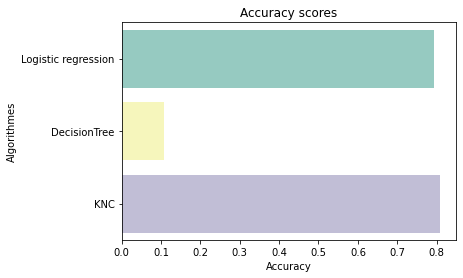

In [24]:

# A decommenter lorsque l'on aura fait tourner tous les modeles
#modeles_accuracy = [log_eval['acc'], tree_eval['acc'], knc_eval['acc'], gbc_eval['acc'], svc_eval['acc'], rfc_eval['acc']]
modeles_accuracy = [log_eval['acc'], tree_eval['acc'], knc_eval['acc']]
#accuracy = pd.DataFrame({"Accuracy":modeles_accuracy,"Algorithmes":["Logistic regression","DecisionTree","KNC","GradientBoosting", "SVC", "RandomForest"]})

accuracy = pd.DataFrame({"Accuracy":modeles_accuracy,
"Algorithmes":["Logistic regression","DecisionTree","KNC"]})

g = sns.barplot("Accuracy","Algorithmes",data = accuracy,palette="Set3",orient = "h")
g.set_xlabel("Accuracy")
g = g.set_title("Accuracy scores")

In [ ]:
#Calculer accuracy+ graphs+comparaison

## Preparation des donées sans la normalisation

In [ ]:
#Encoder les variables catégoriels 
dummies_source = pd.get_dummies(df.source)
dummies_browser = pd.get_dummies(df.browser)
dummies_sex = pd.get_dummies(df.sex)

#Concatenation des vars cat encoder avec notre df:
df_ML = pd.concat([df, dummies_source, dummies_browser, dummies_sex], axis = 'columns')
df_ML.head(3)

In [ ]:
#Convertir les valeurs device_id et ip_address en int
number = preprocessing.LabelEncoder()
df_ML["device_id"] = number.fit_transform(df_ML.device_id)
df_ML["ip_address"] = number.fit_transform(df_ML.ip_address)

print(df_ML[["device_id","ip_address"]].head())


Suppression des variables qui ne seront plus utlise pour l'entraînement du modèle:

In [ ]:
# Suppression des colonnes purchase_time, signup_time, extra 'source', 'browser', 'sex' qui ne seront pas utile pour la prédiction
df_ML = df_ML.drop(['purchase_time', 'signup_time', 'source', 'browser', 'sex'], axis = 1)

df_ML.head()## Undersampling

Pour entrainer et valider les performances de notre modèle, nous allons séparer le jeu de données en jeu d'entrainement et jeu de test.

In [ ]:
#Definition X et y:

X = df_ML.drop(['is_fraud'], axis = 1)
y = df_ML.is_fraud

# split into 70:30 ration
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
  
# describes info about train and test set
print("Nombre de transactions X_train dataset: ", X_train.shape)
print("Nombre de transactions y_train dataset: ", y_train.shape)
print("Nombre de transactions X_test dataset: ", X_test.shape)
print("Nombre de transactions y_test dataset: ", y_test.shape) 

On peut également ajouter une étape de preprocessing à notre modélisation, pour notamment normaliser les données.

## Undersampling

Pour équilibrer la distribution des classes en éliminant au hasard des exemples de classe majoritaire, nous allons utilisé dans un premier temps NearMiss est une technique de sous-échantillonnage ( Undersampling ) qui consiste à supprimer les instances de la classe majoritaire pour augmenter les espaces entre les deux classes lorsque les instances de deux classes différentes sont très proches l'une de l'autre.

In [ ]:
print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0)))
  
# apply near miss

nr = NearMiss()
  
X_train_under, y_train_under = nr.fit_resample(X_train, y_train.ravel())
  
print('After Undersampling, the shape of train_X: {}'.format(X_train_under.shape))
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_under.shape))
  
print("After Undersampling, counts of label '1': {}".format(sum(y_train_under == 1)))
print("After Undersampling, counts of label '0': {}".format(sum(y_train_under == 0)))

Après avoir appliquer le méthode undersampling nous constatons qu'on a eu un équilibre entre les deux classes pour une valeur de 9994 labels chacune.

In [ ]:
# train the model on train set
gbc = GradientBoostingClassifier()
gbc.fit(X_train_under, y_train_under.ravel())
y_pred = gbc.predict(X_test)
  
# print classification report
print(classification_report(y_test, y_pred))

Le modèle choisi est le Gradient boosting qui donne un score de 95% ce qui est plutôt bien.

il classe mieux la classe majoritaire avec 99% ce qui est parfait par contre il classe moins bien la classe minoritaire avec 56%  

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
confusion_matrix

Notre modèle nous donne un trés bonne prédiciton sur la classe 0 et beaucoup moins sur la classe 1 cela du au nombre élevé de la classe 0

- Notre modèle classe 2126 transactions fraudulauses (faux positif) sur 39051 transactions non fraudulauses.
- Notre modèle classe 1765 transactions non fraudulauses (vrai négatif) sur 2392  transactions fraudulauses

# Oversampling

Dans un second temps, nous allons appliquer la technique SMOTE (technique de suréchantillonnage minoritaire synthétique) qui vise à équilibrer la distribution des classes en augmentant de manière aléatoire les exemples de classes minoritaires en les reproduisant.

In [ ]:
# Utilisation la méthode OverSampling (SMOTE) pour équilibrer les données 
sm = SMOTE(random_state = 2)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train.ravel())

print("Avant OverSampling, Nbs transactions frauduleuse '1': {}".format(sum(y_train == 1)))
print("Avant OverSampling, Nbs transactions non frauduleuse'0': {} \n".format(sum(y_train == 0)))
  
print('Après OverSampling, Nombre de transactions train_X: {}'.format(X_train_over.shape))
print('Après OverSampling, Nombre de transactions train_y: {} \n'.format(y_train_over.shape))
  
print("Après OverSampling, Nbs transactions frauduleuse '1': {}".format(sum(y_train_over == 1)))
print("Après OverSampling, Nbs transactions non frauduleuse '0': {}".format(sum(y_train_over == 0)))

Après avoir appliquer le méthode oversampling nous constatons qu'on a eu un équilibre entre les deux classes pour une valeur de 95784 labels chacune. 

In [ ]:
# train the model on train set
gbc2 = GradientBoostingClassifier()
gbc2.fit(X_train_over, y_train_over.ravel())
y_pred2 = gbc2.predict(X_test)
  
# print classification report
print(classification_report(y_test, y_pred2))

In [ ]:
accuracy_score(y_test, y_pred2)

Nous constatons que la technique Oversampling à un meilleur score que Undersampling avec une différence de 1%.  Un peu près

In [ ]:
confusion_matrix = pd.crosstab(y_test, y_pred2, rownames=['Classe réelle'], colnames=['Classe prédite'])
confusion_matrix